# Beware of your car and belongings in Seattle's District E


## Main results
From the analysis of crime data collected during the Summer 2014 by the Police department of Seattle, we found that thefts constitute the most important offense in terms of volume. While this is true across the city, District E seems strongly affected, especially during weekend nights, i.e. on Fridays, Saturdays and Sundays between ~00:00 and 01:00, when such activities increase in frequency with respect to weeknights. Car prowl is the predominant type of theft there.

The steps laid out below provide details into the computations and visualizations used to reach these conclusions.

## Data source
The data used here were made available on the Data Science At Scale [Github repo](https://github.com/uwescience/datasci_course_materials/blob/master/assignment6/crimeanalytics.md). The original data source come from the [data.seattle.gov](https://data.seattle.gov/Public-Safety/Crime/jydm-466h) website.


## Additional information
The districts referred to here correspond to Police precincts. The image below shows them overlaid on top of a map of Seattle. District E, which we will discuss most, is part of the East Precinct. It is a very small geographic area but rich in criminal activity.
![Seattle Police Precincts Map](seattle_precinct_map_small.png "Seattle Precinct Map")

## Analysis
The elements provided below focus on the primary results that led to the conclusions presented in the "Main results" section. A more detailed and exploratory analysis is available [here](https://github.com/alexandrateste/SeattleCrimes/blob/master/ExploratoryAnalysis_SeattleCrimes.ipynb).

Best rendering of the embedded maps is on [nbviewer](http://nbviewer.jupyter.org/github/alexandrateste/SeattleCrimes/blob/master/BewareOfYourBelongingsInSeattleDistrictE.ipynb).

### Loading and manipulation of data:

In [40]:
%matplotlib inline

# Loading of libraries
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as Normalize
import matplotlib.cm as cm
import folium
import branca
import branca.colormap as cm
from dateutil import parser
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.core.display import HTML

# Extraction of data from csv file and storage into a data frame
file = 'seattle_incidents_summer_2014.csv'
df = pd.read_csv(file)
print "Dimensions:", df.shape
df.head(2)

Dimensions: (32779, 19)


,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Date Reported,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year
0,483839,2015218538,2202,0,BURGLARY-FORCE-RES,2200,BURGLARY,06/28/2015 10:31:00 AM,06/28/2014 10:31:00 AM,06/28/2015 10:31:00 AM,6XX BLOCK OF NW 74 ST,J,J2,2900.3013,-122.364672,47.682524,"(47.68252427, -122.364671996)",6,2014
1,481252,2015213067,2610,0,FRAUD-IDENTITY THEFT,2600,FRAUD,06/24/2015 11:09:00 AM,06/01/2014 12:00:00 AM,06/24/2015 11:09:00 AM,23XX BLOCK OF 43 AV E,C,C2,6300.1004,-122.277080,47.639901,"(47.639900761, -122.277080248)",6,2014


Among the pieces of information available in this dataset, we focused on General Offense Number, Offense Type, Occurred date or date range start, District/Sector, Latitude and Longitude.

As indicated above, more details are available in the accompanying ipython notebook. From the results described there, the total number of crimes has not changed much over the 3 summer months of 2014 (June to August). We are then looking at the data in aggregate over these 3 months here.

We first aggregated the types of crimes based on the "Offense Type" field, by essentially removing anything after the "-", and then grouping the records by the crime types obtained. Doing this way allowed us to keep "Theft of service" out of the "Theft" category.

In [41]:
# Creation of new "Shorten Offense" column that contains a short version of the Offense Types
df['Shorten offense'] = [x.split('-')[0] for x in df['Offense Type']]
df['Shorten offense'] = [x.strip() for x in df['Shorten offense']]
df.ix[df['Shorten offense'] == 'PROSTITUTION LOITERING','Shorten offense'] = 'PROSTITUTION'
df.ix[df['Shorten offense'] == 'PROSTITUTION PATRONIZING','Shorten offense'] = 'PROSTITUTION'
df.ix[df['Shorten offense'] == 'VIOL','Shorten offense'] = 'VIOLENCE'
df.ix[df['Shorten offense'] == 'VEH','Shorten offense'] = 'VEH. THEFT'
df.ix[df['Shorten offense'] == 'DRIVE','Shorten offense'] = 'DRIVE-BY'
df.ix[df['Shorten offense'] == '[INC','Shorten offense'] = '[INC - CASE DC USE ONLY]'

In [42]:
# Grouping of records by Shorten Offense (simple count)
crimes_type = pd.DataFrame(df.groupby(['Shorten offense'])['General Offense Number'].count())
# Comutation of percentage vs. overall number of crimes
crimes_type = 100.* crimes_type / crimes_type.sum()
crimes_type.columns = ['Percent']
crimes_type = crimes_type.sort_values(by=['Percent'], ascending=[False])

### Theft: the most common crime

As shown in Figure 1, theft is by far the type of crime that occurs the most. They represent 37% of all the crimes committed during the summer 2014. They are followed by burglaries (11%), vehicle theft (9%), property damage (7%) and assault (6%).

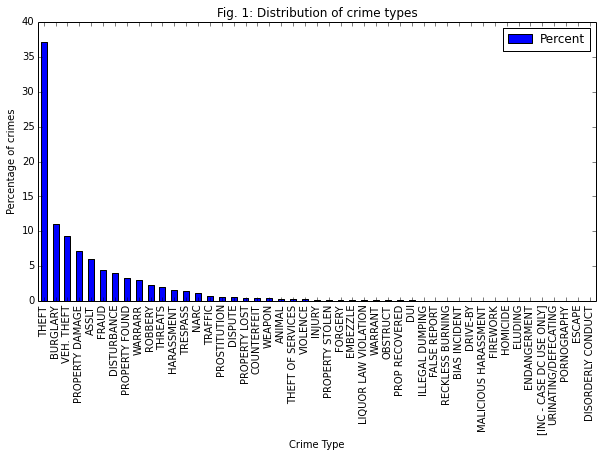

In [43]:
# Distribution of crimes
plt.figure(1)
plt.rcParams["figure.figsize"] = [10,5]
crimes_type.plot(kind='bar')
plt.ylabel('Percentage of crimes')
plt.xlabel('Crime Type')
plt.title('Fig. 1: Distribution of crime types')

To identify potential temporal and spatial patterns, we considered the distribution of all crimes, and of thefts only as a function of time of day. Figure 2 shows a peak in criminal activity at lunch time and at night, between 00:00 and  01:00, i.e. when most people are asleep.

To create this plot, we extracted the hour of occurrence from the "Occurred Date or Date Range Start" field.

In [44]:
# Parsing of the start date of each event into a date time, a day name and an hour
df['Datetime Occurred'] = pd.to_datetime(df['Occurred Date or Date Range Start'])
df['Occurred Day'] = df['Datetime Occurred'].dt.weekday_name
df['Occurred Hour'] = df['Datetime Occurred'].dt.hour
thefts_hist = df[df['Shorten offense']=='THEFT']

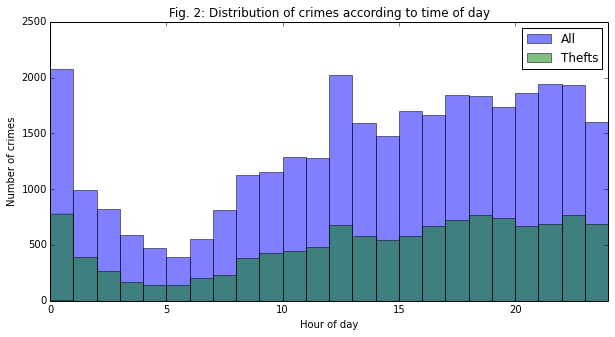

In [45]:
plt.figure(2)
df['Occurred Hour'].plot(kind='hist', bins=range(0,25,1),alpha=0.5, label='All')
thefts_hist['Occurred Hour'].plot(kind='hist', bins=range(0,25,1),alpha=0.5, color='green', label='Thefts')
plt.xlim([0,24])
plt.legend(loc='upper right')
plt.ylabel('Number of crimes')
plt.xlabel('Hour of day')
plt.title('Fig. 2: Distribution of crimes according to time of day')

Leveraging this distribution, and thinking about working hours, we defined 4 time periods:
- Morning: 06:00 - 12:00
- Lunch: 12:00 - 13:00
- Afternoon: 13:00 - 19:00
- Evening: 19:00 - 23:00
- Night: 23:00 - 06:00

In [46]:
# Definition of time periods
df['Period'] = np.nan
df.ix[((df['Occurred Hour']>=6.) & (df['Occurred Hour']<12.)), 'Period'] = 'Morning'
df.ix[((df['Occurred Hour']>=12.) & (df['Occurred Hour']<13.)), 'Period'] = 'Lunch'
df.ix[((df['Occurred Hour']>=13.) & (df['Occurred Hour']<19.)), 'Period'] = 'Afternoon'
df.ix[((df['Occurred Hour']>=19.) & (df['Occurred Hour']<23.)), 'Period'] = 'Evening'
df.ix[((df['Occurred Hour']>=23.) | (df['Occurred Hour']<6.)), 'Period'] = 'Night'

Figure 2 also shows that, cumulatively, most of the thefts happen in the afternoon, between 13:00 and 19:00. This is true overall across all types of crimes (blue), but also, and mainly due to thefts (green). Over the 3 summer months of 2014, 3864 crimes were committed in the afternoon (13:00-19:00), 2863 during the evening (19:00-23:00), and 2583 at night (23:00-06:00).

In [47]:
thefts_hist = df[df['Shorten offense']=='THEFT']
print(thefts_hist[thefts_hist['Period']=='Afternoon']['General Offense Number'].count())
print(thefts_hist[thefts_hist['Period']=='Evening']['General Offense Number'].count())
print(thefts_hist[thefts_hist['Period']=='Night']['General Offense Number'].count())

3864
2863
2583


We used these time periods to see if differences could be detected between days of the week, focusing only on thefts.

In [48]:
# Grouping of thefts per day and time period
theft_day_period = df[df['Shorten offense'] == 'THEFT'].groupby(['Occurred Day', 'Period'])['General Offense Number'].count().unstack('Period')

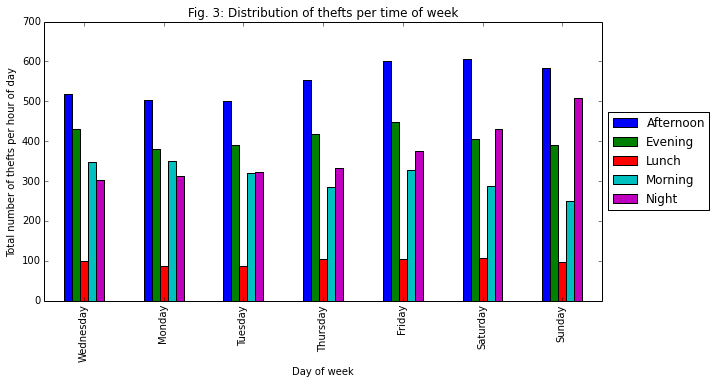

In [49]:
plt.figure(3)
theft_day_period= theft_day_period.sort_values(by=['Night'], ascending=[True])

theft_day_period.plot(kind='bar', stacked=False).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Total number of thefts per hour of day')
plt.xlabel('Day of week')
plt.title('Fig. 3: Distribution of thefts per time of week')

As seen above, most crimes occurred during the afternoon, i.e. between 13:00 and 19:00. While their number seems to increase at the end of the week, the trend observed is less stark (+20%) than the one seen for nightly activity (+66%). Indeed, more thefts occur on weekend nights than on week nights (purple), presumably because more people go out and are potential "preys". The rest of the study below focuses on trends observed at night (i.e. between 23:00 and 06:00, but mainly between 00:00 and 01:00).

### Nightly thefts

After grouping theft events per day and District, it became apparent that District E was different from the others. It is indeed the precinct in which the number of thefts increases drastically over the weekend (cf. first purple bar on Figure 4). Thefts in that part of town represent up to 18% of all thefts then. This goes down to ~ 10% on Mondays, is at its minimum on Wednesday (~5%), and starts going back up on Thursdays.

In [50]:
# Extraction of nightly thefts as a function of day of week
# Computation of percentage of occurrence in each district in a given day
nightly_thefts = pd.DataFrame(df[(df['Shorten offense'] == 'THEFT') & (df['Period'] == 'Night')].groupby(['Occurred Day', 'District/Sector'])['General Offense Number'].count().unstack('District/Sector'))
nightly_thefts_perc = nightly_thefts.apply(lambda x: x / x.sum() * 100, axis=1)
nightly_thefts_perc = nightly_thefts_perc.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

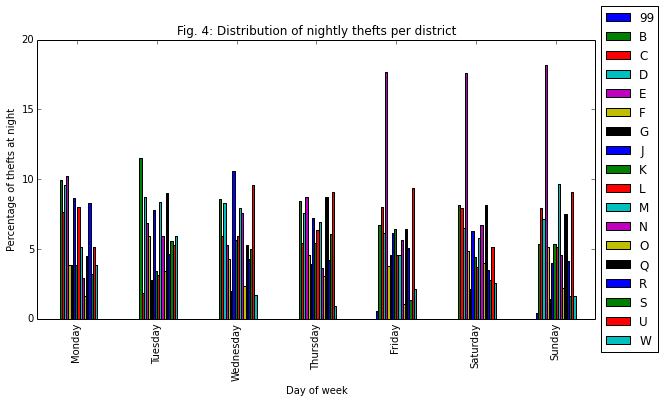

In [51]:
plt.figure(4)
nightly_thefts_perc.plot(kind='bar', stacked=False).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Percentage of thefts at night')
plt.xlabel('Day of week')
plt.title('Fig. 4: Distribution of nightly thefts per district')

The map below provides a better sense for where thefts are occurring. Here too, District E emerges as the most risky part of town. *(By selecting a day in each of the drop-downs (when one downloads the notebook on his/her machine), one can see the difference in activity between 2 different days. Those shown here are Wednesdays and Sundays.)* The biggest difference, especially for District E, is between Wednesdays (total of 16 events over the three months) and Sundays (92 events).

Please, click on the circles to display their District/Sector names and total number of thefts.

In [52]:
# Extraction of nightly thefts
nightly_thefts_all0 = df[(df['Shorten offense'] == 'THEFT') & (df['Period'] == 'Night')]
nightly_thefts_all = nightly_thefts_all0.copy()

# Replacement of empty district name by 'A'
nightly_thefts_all['District/Sector'].fillna('A', inplace=True)

In [56]:
# List of days displayed in the drop-downs
day_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Grouping of nightly thefts by day of week
theft_count = nightly_thefts_all.groupby(['Occurred Day', 'District/Sector'])['General Offense Number'].count().unstack('District/Sector')

# Removal of records which latitude and or longitude = 0 degrees,
# to obtain a physically realistic position of the circles on the map
# Note that these records are still counted in the total displayed on the maps
theft_lat = nightly_thefts_all[nightly_thefts_all['Latitude']!=0.0].groupby(['Occurred Day', 'District/Sector'])['Latitude'].mean().unstack('District/Sector')
theft_lon = nightly_thefts_all[nightly_thefts_all['Longitude']!=0.0].groupby(['Occurred Day', 'District/Sector'])['Longitude'].mean().unstack('District/Sector')

# Removal of districts referred to as '99' or without any name at all,
# as it seems that the former designation is given when the actual district name is unknown
# and that the latter is due to missing information
theft_count= theft_count.drop(['99', 'A'], axis=1)
theft_lat= theft_lat.drop(['99'], axis=1)  # theft_lat and theft_lon do not contain an 'A' column
theft_lon= theft_lon.drop(['99'], axis=1)

color_dict=dict(B='blue', C='cyan', D='olive',
                E='purple', F='fushia', G='green',
                J='yellow', K='khaki', L='salmon',
                M='magenta', N='lime', O='orange',
                Q='slategrey', R='red', S='brown',
                U='gold', W='lavender')

selection_left=widgets.Dropdown(description='Left: Day of week?')
selection_left.options=day_of_week
selection_left.value='Wednesday'

def on_button_clicked(b):
    clear_output(wait=True)
    display(plt.gcf())

    map = folium.Map(location=[47.607055,-122.321494], zoom_start=10, tiles='Stamen Terrain')

    for col in theft_count.columns:
        folium.CircleMarker([theft_lat.ix[selection_left.value,col], 
                             theft_lon.ix[selection_left.value,col]], 
                             radius=100.*np.sqrt(theft_count.ix[selection_left.value,col]),
                             fill_color=color_dict[col],
                             color=color_dict[col],
                             popup=folium.Popup(', '.join([col, str(int(theft_count.ix[selection_left.value,col]))+' events']))).add_to(map)

    map.save('Nightly_thefts_map_left.html')
    display(HTML('<iframe width="45%" height="350" src="Nightly_thefts_map_left.html" align="left"></iframe>'
                 '<iframe width="45%" height="350" src="Nightly_thefts_map_right.html" align="right"></iframe>'))

selection_left.observe(on_button_clicked)
display(selection_left)

# Help: https://medium.com/@captain_eli/3-ways-to-make-interactive-graphs-in-jupyter-notebooks-154cbb4796a9#.du361ot84    

selection_right=widgets.Dropdown(description='Right: Day of week?')
selection_right.options=day_of_week
selection_right.value='Sunday'

def on_button_clicked2(b):
    clear_output(wait=True)
    display(plt.gcf())

    map = folium.Map(location=[47.607055,-122.321494], zoom_start=10, tiles='Stamen Terrain')

    for col in theft_count.columns:
        folium.CircleMarker([theft_lat.ix[selection_right.value,col], 
                             theft_lon.ix[selection_right.value,col]], 
                             radius=100*np.sqrt(theft_count.ix[selection_right.value,col]),
                             fill_color=color_dict[col],
                             color=color_dict[col],
                             popup=folium.Popup(', '.join([col, str(int(theft_count.ix[selection_right.value,col]))+' events']))).add_to(map)
       
    map.save('Nightly_thefts_map_right.html')
    display(HTML('<iframe width="45%" height="350" src="Nightly_thefts_map_left.html" align="left"></iframe>'
                 '<iframe width="45%" height="350" src="Nightly_thefts_map_right.html" align="right"></iframe>'))

selection_right.observe(on_button_clicked2)
display(selection_right)


Note: Records with districts referred to as '99' or without any name at all were removed, as it seems that the former designation is given when the actual district name is unknown and that the latter is due to missing information

### Types of theft

As seen before, the total number of thefts increases over the weekend. This trend is mainly driven by car prowls (cf. Figure 6a), which are by far the most numerous type of theft experienced in District E. Other types of theft also follow the same trend; theft by pick-pockets, and other unspecified activities. Thus, the relative importance of car prowls decreases over the weekend (Figure 6b). While the absolute number of car prowls in highest on Fridays, Saturdays and Sundays, their relative weight is biggest on Saturdays, Sundays and Mondays (and not Fridays).

In [54]:
# Extraction of nightly theft types in District E
district_e_theft_types = pd.DataFrame(df[(df['Shorten offense'] == 'THEFT') & (df['Period'] == 'Night') & (df['District/Sector'] == 'E')].groupby(['Occurred Day', 'Offense Type'])['General Offense Number'].count().unstack('Offense Type'))
district_e_theft_types = district_e_theft_types.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Distribution of theft types for a given day
district_e_thefts_perc = district_e_theft_types.apply(lambda x: x / x.sum() * 100, axis=1)
district_e_thefts_perc = district_e_thefts_perc.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

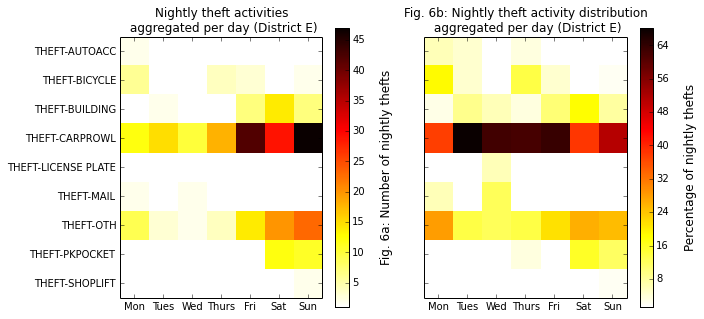

In [55]:
# Conversion of the data frames into a matrices for heatmap representation
matr = district_e_theft_types.as_matrix().transpose()
matr_perc = district_e_thefts_perc.as_matrix().transpose()

plt.subplot(1,2,1)
plt.imshow(matr, cmap='hot_r', interpolation='nearest')
plt.xticks([0,1,2,3,4,5,6], ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.yticks([0,1,2,3,4,5,6,7,8], district_e_theft_types.columns)
cbar = plt.colorbar()
plt.title('Nightly theft activities \n aggregated per day (District E)')
cbar.set_label('Fig. 6a: Number of nightly thefts', rotation=90, labelpad=15, fontsize=12)

plt.subplot(1,2,2)
plt.imshow(matr_perc, cmap='hot_r', interpolation='nearest')
plt.xticks([0,1,2,3,4,5,6], ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.yticks([0,1,2,3,4,5,6,7,8], ['','','','','','','','',''])
cbar = plt.colorbar()
plt.title('Fig. 6b: Nightly theft activity distribution \n aggregated per day (District E)')
cbar.set_label('Percentage of nightly thefts', rotation=90, labelpad=15, fontsize=12)

## Conclusion

Thefts are the most crime reported overall in Seattle. Most of them happen in the afternoon and evening, i.e. between 13:00 and 23:00. A good number of them also happen at night (23:00-06:00). While afternoon thefts increase over the weekend, nightly events increase the most relative to weekdays.

Not all districts experience the same level of criminal activity. District E is the area of Seattle where nightly thefts are the most numerous, with a high proportion of car prowls.

So, if you go out late at night in District E, beware of your car and belongings.